In [ ]:
from google.colab import files
uploaded = files.upload()
# Select your downloaded CO2Wounds-V2.zip file


Saving CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients.zip to CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients (1).zip


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


True
Tesla T4


In [ ]:
import zipfile, io
zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[next(iter(uploaded))]), 'r')
zip_ref.extractall('/content/co2wounds')
zip_ref.close()


In [ ]:
import os,glob

# Paths
IMG_DIR = '/content/co2wounds/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/imgs'
MASK_DIR = '/content/co2wounds/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/masks'

# Build dictionaries mapping basename to path
img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in glob.glob(f"{IMG_DIR}/*.jpg")}
mask_map = {os.path.splitext(os.path.basename(p))[0]: p for p in glob.glob(f"{MASK_DIR}/*.png")}

# Find common base names (paired samples)
common = sorted(set(img_map) & set(mask_map))
print(f"✅ Total paired samples: {len(common)}")

# Prepare matched lists
imgs = [img_map[b] for b in common]
masks = [mask_map[b] for b in common]

# Perform train-validation split
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    imgs, masks, test_size=0.2, random_state=42
)


✅ Total paired samples: 454


In [ ]:
from torchvision import transforms
import albumentations as A
# Install dependencies
!pip install segmentation-models-pytorch albumentations --quiet

# Imports
import os, glob, torch, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import torch.optim as optim


class WoundDataset(Dataset):
    def __init__(self, imgs, masks, transforms=None):
        self.imgs, self.masks, self.transforms = imgs, masks, transforms
    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        img = cv2.cvtColor(cv2.imread(self.imgs[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], cv2.IMREAD_GRAYSCALE)
        data = self.transforms(image=img, mask=mask)
        X = data['image'].astype('float32')/255.
        Y = data['mask'].astype('float32')
        return torch.tensor(X.transpose(2,0,1)), torch.tensor(Y).unsqueeze(0)

# Basic augmentations
transform = A.Compose([
    A.Resize(256, 256),
])

# Create dataset objects
train_ds = WoundDataset(train_imgs, train_masks, transforms=transform)
val_ds = WoundDataset(val_imgs, val_masks, transforms=transform)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)



In [ ]:
import segmentation_models_pytorch as smp
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import iou_score

criterion = DiceLoss(mode="binary")
metric_fn = iou_score
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.to(device)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
!pip install segmentation-models-pytorch albumentations

import glob, torch
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
import numpy as np
from sklearn.model_selection import train_test_split
!pip install torchmetrics
from torchmetrics.classification import BinaryJaccardIndex
metric_fn = BinaryJaccardIndex().to(device)

class WoundDataset(Dataset):
    def __init__(self, imgs, masks, transforms=None):
        self.imgs, self.masks, self.transforms = imgs, masks, transforms
    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        img = cv2.cvtColor(cv2.imread(self.imgs[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], cv2.IMREAD_GRAYSCALE)
        data = self.transforms(image=img, mask=mask)
        X = data['image'].astype('float32')/255.
        Y = (data['mask']>127).astype('float32')
        return torch.tensor(X.transpose(2,0,1)), torch.tensor(Y).unsqueeze(0)

# Prepare file lists and splits
IMG_DIR = '/content/co2wounds/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/imgs'
MASK_DIR = '/content/co2wounds/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients/masks'

# Gather dictionaries mapping basenames to paths
img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in glob.glob(f"{IMG_DIR}/*.jpg")}
mask_map = {os.path.splitext(os.path.basename(p))[0]: p for p in glob.glob(f"{MASK_DIR}/*.png")}

# Find common base filenames
common = sorted(set(img_map) & set(mask_map))
print(f"✅ Total paired samples: {len(common)}")

# Build matched lists
imgs = [img_map[b] for b in common]
masks = [mask_map[b] for b in common]

# Now split correctly
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    imgs, masks, test_size=0.2, random_state=42
)


✅ Total paired samples: 454


In [ ]:
def eval_epoch(dl):
    model.eval()
    L = I = 0
    with torch.no_grad():
        for X, Y in dl:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            L += criterion(pred, Y).item()
            preds = (pred > 0.5).int()
            I += metric_fn(preds, Y.int()).item()
    return L / len(dl), I / len(dl)


In [ ]:
def train_epoch(dl, optimizer):
    model.train()
    total_loss = 0
    for X, Y in dl:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dl)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
X_batch, Y_batch = next(iter(train_loader))
print("X_batch shape:", X_batch.shape)
print("Y_batch unique values:", torch.unique(Y_batch))


X_batch shape: torch.Size([8, 3, 256, 256])
Y_batch unique values: tensor([0., 1.])


Mask unique values before thresholding: [0 1]


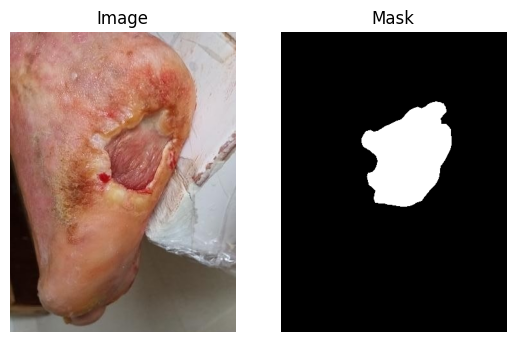

In [ ]:
import matplotlib.pyplot as plt

img = cv2.cvtColor(cv2.imread(train_imgs[0]), cv2.COLOR_BGR2RGB)
mask = cv2.imread(train_masks[0], cv2.IMREAD_GRAYSCALE)

print("Mask unique values before thresholding:", np.unique(mask))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis("off")

plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    out = model(X_batch.to(device))
    print("Model output shape:", out.shape)
    print("Min, Max in output:", out.min().item(), out.max().item())
    print("Unique values in thresholded output (>0.5):", torch.unique((out > 0.5).int()))

Model output shape: torch.Size([8, 1, 256, 256])
Min, Max in output: 0.40176311135292053 0.9979154467582703
Unique values in thresholded output (>0.5): tensor([0, 1], device='cuda:0', dtype=torch.int32)


In [ ]:
print("Y_batch shape:", Y_batch.shape)
print("Y_batch dtype:", Y_batch.dtype)
print("Y_batch device:", Y_batch.device)


Y_batch shape: torch.Size([8, 1, 256, 256])
Y_batch dtype: torch.float32
Y_batch device: cpu


In [ ]:
smooth = 1e-5
preds = (out > 0.5).float()
targets = Y_batch.to(device).float()

intersection = (preds * targets).sum()
union = preds.sum() + targets.sum()

dice = (2. * intersection + smooth) / (union + smooth)
print("Manual Dice Coefficient:", dice.item())
print("Manual Dice Loss:", 1 - dice.item())


Manual Dice Coefficient: 0.2928859293460846
Manual Dice Loss: 0.7071140706539154


In [ ]:
X_batch, Y_batch = next(iter(train_loader))
print(torch.unique(Y_batch))  # should print tensor([0., 1.])

tensor([0., 1.])


In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, val_iou = eval_epoch(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")



Epoch 1/30 | Train Loss: 0.7906 | Val Loss: 0.8338 | Val IoU: 0.2544
Epoch 2/30 | Train Loss: 0.7789 | Val Loss: 0.8293 | Val IoU: 0.3946
Epoch 3/30 | Train Loss: 0.7749 | Val Loss: 0.8275 | Val IoU: 0.3385
Epoch 4/30 | Train Loss: 0.7679 | Val Loss: 0.8245 | Val IoU: 0.4597
Epoch 5/30 | Train Loss: 0.7676 | Val Loss: 0.8236 | Val IoU: 0.4606
Epoch 6/30 | Train Loss: 0.7665 | Val Loss: 0.8212 | Val IoU: 0.4796
Epoch 7/30 | Train Loss: 0.7628 | Val Loss: 0.8232 | Val IoU: 0.6119
Epoch 8/30 | Train Loss: 0.7617 | Val Loss: 0.8192 | Val IoU: 0.5582
Epoch 9/30 | Train Loss: 0.7639 | Val Loss: 0.8187 | Val IoU: 0.5024
Epoch 10/30 | Train Loss: 0.7634 | Val Loss: 0.8185 | Val IoU: 0.4549
Epoch 11/30 | Train Loss: 0.7600 | Val Loss: 0.8168 | Val IoU: 0.5173
Epoch 12/30 | Train Loss: 0.7586 | Val Loss: 0.8164 | Val IoU: 0.5673
Epoch 13/30 | Train Loss: 0.7552 | Val Loss: 0.8158 | Val IoU: 0.6027
Epoch 14/30 | Train Loss: 0.7579 | Val Loss: 0.8152 | Val IoU: 0.5780
Epoch 15/30 | Train Loss: 0.7

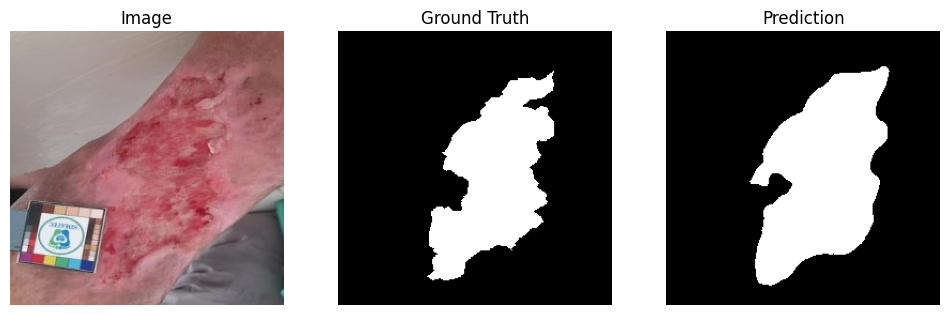

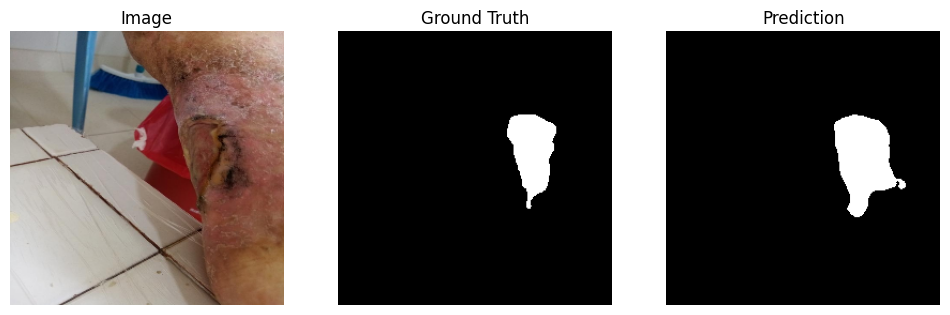

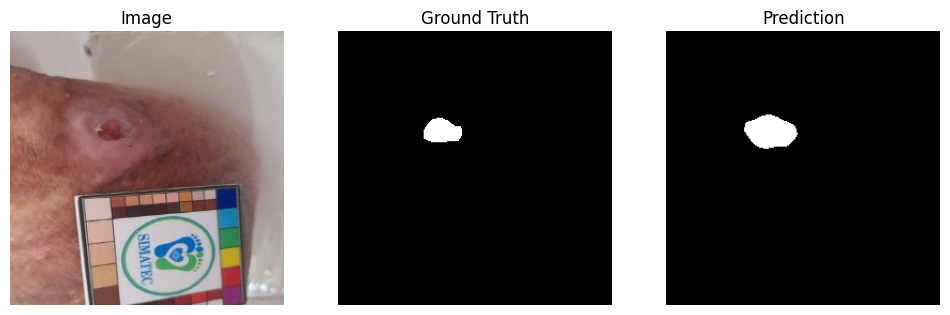

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        pred_mask = (pred > 0.5).float().cpu()

        for i in range(3):  # show 3 samples
            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.title("Image")
            plt.imshow(X_batch[i].cpu().permute(1,2,0))
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Ground Truth")
            plt.imshow(Y_batch[i][0], cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Prediction")
            plt.imshow(pred_mask[i][0], cmap='gray')
            plt.axis('off')

            plt.show()
        break


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        outputs = model(X_batch)
        preds = (outputs > 0.5).int()

        all_preds.extend(preds.cpu().numpy().reshape(-1))
        all_targets.extend(Y_batch.cpu().numpy().reshape(-1))

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Compute metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.9592
Precision: 0.6727
Recall: 0.9211


In [ ]:
torch.save(model.state_dict(), "wound_unet_segmentation.pth")
print("✅ Model saved successfully.")


✅ Model saved successfully.


In [ ]:
# Modify encoder/architecture as per your training
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(device)

model.load_state_dict(torch.load("wound_unet_segmentation.pth", map_location=device))
model.eval()
print("✅ Model loaded and ready for inference.")


✅ Model loaded and ready for inference.


In [ ]:
def process_wound_image(image):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # Calculate wound area
    pixel_area_cm2 = 0.01  # adjust based on dataset calibration
    wound_area_pixels = np.sum(mask)
    wound_area_cm2 = wound_area_pixels * pixel_area_cm2

    # Severity classification
    if wound_area_cm2 < 5:
        severity = "Mild (Green)"
        color = (0, 255, 0)
    elif wound_area_cm2 < 20:
        severity = "Moderate (Yellow)"
        color = (255, 255, 0)
    else:
        severity = "Severe (Red)"
        color = (255, 0, 0)

    # Overlay visualization
    overlay = np.array(image.resize((256, 256))).copy()
    overlay[mask == 1] = overlay[mask == 1] * 0.5 + np.array(color) * 0.5
    overlay_img = Image.fromarray(overlay.astype(np.uint8))

    return overlay_img, f"Wound Area: {wound_area_cm2:.2f} cm²\nSeverity: {severity}"


In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=7b2f316e184178bd017591fceaf60b21cdb3546e8759f03e08228cfcec7d6fa9
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
!pip install pyttsx3

In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import torch
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
import torchvision.transforms as T
import cv2
from fpdf import FPDF
import os

# ------------------ Configs ------------------ #
st.set_page_config(page_title="Leprosy Wound Analyzer", layout="centered")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ Model Load ------------------ #
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation="sigmoid"
)
model.load_state_dict(torch.load("/content/wound_unet_segmentation.pth", map_location=device))
model.eval().to(device)

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# ------------------ UI ------------------ #
st.title("🩹 Leprosy Wound Segmentation & Tissue Analysis")

st.subheader("📋 Enter Patient Information")
patient_name = st.text_input("Patient Name")
patient_age = st.text_input("Patient Age")
patient_id = st.text_input("Patient ID")
clinician_notes = st.text_area("Clinician Notes (optional)")

uploaded_file = st.file_uploader("Upload Leprosy Wound Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # ------------------ Multi-Wound Detection ------------------ #
    num_labels, labels_im = cv2.connectedComponents(mask.astype(np.uint8))
    overlay = np.array(image.resize((256, 256))).copy()
    wound_areas = []
    total_wound_pixels = 0

    for wound_idx in range(1, num_labels):
        wound_mask = (labels_im == wound_idx).astype(np.uint8)
        wound_pixels = np.sum(wound_mask)
        total_wound_pixels += wound_pixels
        pixel_area_cm2 = 0.01  # adjust calibration
        wound_area_cm2 = wound_pixels * pixel_area_cm2
        wound_areas.append(wound_area_cm2)
        overlay[wound_mask == 1] = overlay[wound_mask == 1] * 0.5 + np.array([255, 255, 0]) * 0.5

    wound_to_limb_ratio = (total_wound_pixels / (256 * 256)) * 100

    # Severity
    total_area = np.sum(wound_areas)
    if total_area < 5:
        severity = "🟩 Mild"
        severity_text = "Mild"
    elif total_area < 20:
        severity = "🟨 Moderate"
        severity_text = "Moderate"
    else:
        severity = "🟥 Severe"
        severity_text = "Severe"

    overlay_img = Image.fromarray(overlay.astype(np.uint8))

    # ------------------ Color-Tissue Classification ------------------ #
    hsv_img = cv2.cvtColor(np.array(image.resize((256, 256))), cv2.COLOR_RGB2HSV)
    granulation_mask = np.logical_and.reduce([
        hsv_img[:, :, 0] >= 0, hsv_img[:, :, 0] <= 10,    # red hue
        hsv_img[:, :, 1] >= 100, hsv_img[:, :, 2] >= 50
    ])
    necrotic_mask = np.logical_and.reduce([
        hsv_img[:, :, 0] >= 0, hsv_img[:, :, 0] <= 180,   # any hue
        hsv_img[:, :, 1] <= 50, hsv_img[:, :, 2] <= 80    # dark, low saturation
    ])
    slough_mask = np.logical_and.reduce([
        hsv_img[:, :, 0] >= 20, hsv_img[:, :, 0] <= 40,   # yellowish
        hsv_img[:, :, 1] >= 50, hsv_img[:, :, 2] >= 50
    ])

    granulation_area = np.sum(granulation_mask & (mask == 1)) * pixel_area_cm2
    necrotic_area = np.sum(necrotic_mask & (mask == 1)) * pixel_area_cm2
    slough_area = np.sum(slough_mask & (mask == 1)) * pixel_area_cm2

    # ------------------ Display Results ------------------ #
    st.subheader("📈 Wound Analysis")
    st.write(f"**Total Wound Area:** {total_area:.2f} cm²")
    st.write(f"**Wound-to-Limb Size Ratio:** {wound_to_limb_ratio:.2f}%")
    st.write(f"**Severity:** {severity}")

    st.subheader("🩺 Tissue Composition (Approx)")
    st.write(f"- **Granulation Tissue:** {granulation_area:.2f} cm²")
    st.write(f"- **Necrotic Tissue:** {necrotic_area:.2f} cm²")
    st.write(f"- **Slough Tissue:** {slough_area:.2f} cm²")

    st.subheader("🖼️ Segmentation Overlay")
    st.image(overlay_img, caption="Overlay of Segmentation", use_container_width=True)

    # ------------------ Automated PDF Generation ------------------ #
    if st.button("📄 Generate PDF Report"):
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)

        pdf.cell(200, 10, txt="Leprosy Wound Analysis Report", ln=True, align="C")
        pdf.ln(5)
        pdf.cell(200, 10, txt=f"Patient Name: {patient_name}", ln=True)
        pdf.cell(200, 10, txt=f"Patient Age: {patient_age}", ln=True)
        pdf.cell(200, 10, txt=f"Patient ID: {patient_id}", ln=True)
        if clinician_notes.strip() != "":
            pdf.multi_cell(0, 10, txt=f"Clinician Notes: {clinician_notes}", align="L")
        pdf.ln(5)
        pdf.cell(200, 10, txt=f"Total Wound Area: {total_area:.2f} cm²", ln=True)
        pdf.cell(200, 10, txt=f"Wound-to-Limb Size Ratio: {wound_to_limb_ratio:.2f}%", ln=True)
        pdf.cell(200, 10, txt=f"Severity: {severity_text}", ln=True)
        pdf.cell(200, 10, txt=f"Granulation Tissue: {granulation_area:.2f} cm²", ln=True)
        pdf.cell(200, 10, txt=f"Necrotic Tissue: {necrotic_area:.2f} cm²", ln=True)
        pdf.cell(200, 10, txt=f"Slough Tissue: {slough_area:.2f} cm²", ln=True)

        img_path = "overlay_temp.png"
        overlay_img.save(img_path)
        pdf.image(img_path, x=10, y=120, w=180)

        pdf_output = "wound_report.pdf"
        pdf.output(pdf_output)

        with open(pdf_output, "rb") as f:
            st.download_button("⬇️ Download PDF Report", f, file_name="wound_report.pdf")


Overwriting streamlit_app.py


In [ ]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.5 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2zp4bBspPy7mwsJQIpQe1ERWTUa_3CppfpAJV9QjJJp4UMLEN")


In [ ]:
from pyngrok import ngrok
ngrok.kill()  # Ensure all ngrok tunnels are killed


In [ ]:
!pip install pyngrok

from pyngrok import ngrok
import threading
import time

# Authenticate ngrok
ngrok.set_auth_token("2zp4bBspPy7mwsJQIpQe1ERWTUa_3CppfpAJV9QjJJp4UMLEN")

# Kill previous tunnels again to ensure cleanup
ngrok.kill()

# Start ngrok tunnel on 8501
public_url = ngrok.connect(8501)
print(f"🔗 Public URL: {public_url}")

# Run Streamlit in a non-blocking thread
def run_app():
    !streamlit run streamlit_app.py

thread = threading.Thread(target=run_app)
thread.start()

# Keep cell alive
while True:
    time.sleep(1)


🔗 Public URL: NgrokTunnel: "https://7932a8b88e97.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.126.141.4:8501



KeyboardInterrupt: 